In [1]:
from decimal import Decimal
import numpy as np
from better_kan import KAN as BetterKAN
from kan import create_dataset,LBFGS
import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy.special

def convert_func(f):
    return lambda x:f(*x.unsqueeze(-1).permute(1,0,2))

def size_of_model(model):
    size=0
    for p in model.parameters():
        size+=p.numel()*p.element_size()
    return size
def params_of_model(model):
    return size_of_model(model)/8
def ellipj(x,y):
    return scipy.special.ellipj(x,y)[0].real.float()

def ellipkinc(x,y):
    return scipy.special.ellipkinc(x,y)

def ellipeinc(x,y):
    return scipy.special.ellipeinc(x,y)

def jv(v,x):
    return scipy.special.jv(v,x)


def yv(v,x):
    return scipy.special.yv(v,x)


def iv(v,x):
    return scipy.special.iv(v,x)

def kv(v,x):
    return scipy.special.kv(v,x)

def lpmv0(m,x):
    return scipy.special.lpmv(0,m,x)

def lpmv1(m,x):
    return scipy.special.lpmv(1,m,x)

def lpmv2(m,x):
    return scipy.special.lpmv(2,m,x)

def sph_harm11(theta,phi):
    return scipy.special.sph_harm(1,1,theta,phi).real.float()

def sph_harm12(theta,phi):
    return scipy.special.sph_harm(1,2,theta,phi).real.float()

def sph_harm22(theta,phi):
    return scipy.special.sph_harm(2,2,theta,phi).real.float()

def sph_harm21(theta,phi):
    return scipy.special.sph_harm(2,1,theta,phi).real.float()
def test_accuracy_1(x):
    return torch.special.bessel_j0(x*20)
def test_accuracy_2(x,y):
    return torch.exp(torch.sin(torch.pi*x)+y**2)
def test_accuracy_3(x,y):
    return x*y
def test_accuracy_4(x1,x2,x3,x4):
    return torch.exp(torch.sin(x1**2+x2**2)+torch.cos(x3**2+x4**2))


# def test_accuracy2(x,y):
#     return torch.exp(torch.special.bessel_j0(x*20)+y**2)

class MLP(torch.nn.Module):
    def __init__(self, in_features, out_features, hidden_dim=128, num_layers=3, activation=torch.nn.SiLU(),seed=0):
        torch.manual_seed(seed)
       
        super(MLP, self).__init__()
        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(in_features, hidden_dim))
        self.layers.append(activation)
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(activation)
        self.layers.append(nn.Linear(hidden_dim, out_features))
    def forward(self, x):
        return self.layers(x)
from tqdm import tqdm
def test_kan(f,ranges,width,device="cuda",steps=50,seed=0,degrees=(5,10,20,50)):
    n_var=width[0]
    print(n_var)
    dataset=create_dataset(convert_func( f),n_var,ranges,device=device,train_num=10000)
    y=dataset["train_label"]
    print(y.min(),y.max()  )
    kan_losses={}
    mlp_losses={}
    
 
        
    for deg in degrees:
        
        print(f"BetterKAN {deg}")
        if deg ==degrees[0]:
            
            kan=BetterKAN(width,deg,device=device,bias_trainable=False,base_fn=...,symbolic_enabled=False).to(device)
        else:
            old=kan
            kan=BetterKAN(width,deg,device=device,bias_trainable=False,base_fn=...,symbolic_enabled=False).to(device)
            # kan.initialize_grid_from_another_model(old,x=dataset["test_input"])
        result=kan.train(dataset,lr=1,steps=steps)
        loss=torch.nn.MSELoss()(kan(dataset["test_input"]),dataset["test_label"])
        kan_losses.update({params_of_model(kan):loss.item()})
        
    
      
    for depth in [3,4,5,6]:
        mlp_loss={}
        mlp_losses[f"MLP depth={depth}"]=mlp_loss
        for features in [8,16,32,64,128,256]:
            mlp=MLP(n_var,1,hidden_dim=features,num_layers=depth,seed=seed).to(device)
            opt=LBFGS(mlp.parameters(),lr=1)
            for _ in tqdm( range(steps)):
                def closure():
                    opt.zero_grad()
                    loss=torch.nn.MSELoss()(mlp(dataset["train_input"]),dataset["train_label"])
                    loss.backward()
                    return loss
                loss=opt.step(closure)
            mlp_loss[params_of_model(mlp)]=loss.item()
    plot,ax=plt.subplots()
    plt.plot(kan_losses.keys(),kan_losses.values(),label="KAN")
    for depth,mlp_loss in mlp_losses.items():
        plt.plot(mlp_loss.keys(),mlp_loss.values(),label=depth)
    plt.legend()
    ax.set_xlabel("Number of parameters")
    ax.set_ylabel("Test MSE")
    ax.set_xscale("log")
    ax.set_yscale("log")
    # ax.set_ylim(1e-10,1)

                
            
            
            


2
tensor(-0.9905, device='cuda:0') tensor(0.9921, device='cuda:0')
BetterKAN 5


train loss: 4.66e-04 | test loss: 4.87e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.34it/s]


BetterKAN 10


train loss: 2.30e-04 | test loss: 2.29e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:09<00:00,  5.38it/s]


BetterKAN 20


train loss: 1.50e-04 | test loss: 1.52e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.37it/s]


BetterKAN 50


train loss: 7.79e-05 | test loss: 7.81e-05 | reg: 0.00e+00 : 100%|██| 50/50 [00:19<00:00,  2.54it/s]
100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


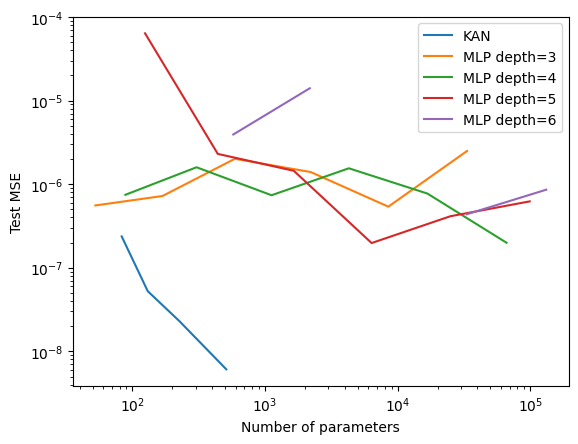

In [2]:
test_kan(ellipeinc,[[-1,1],[0,1]],[2,3,1])

2
tensor(-0.8363, device='cuda:0') tensor(0.8372, device='cuda:0')
BetterKAN 5


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 1.75e-04 | test loss: 1.70e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:22<00:00,  2.24it/s]


BetterKAN 10


train loss: 7.87e-05 | test loss: 7.85e-05 | reg: 0.00e+00 : 100%|██| 50/50 [00:23<00:00,  2.16it/s]


BetterKAN 20


train loss: 1.64e-04 | test loss: 1.52e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:12<00:00,  4.06it/s]


BetterKAN 50


train loss: 5.52e-05 | test loss: 5.50e-05 | reg: 0.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.30it/s]
100%|██████████| 50/50 [00:02<00:00, 23.38it/s]


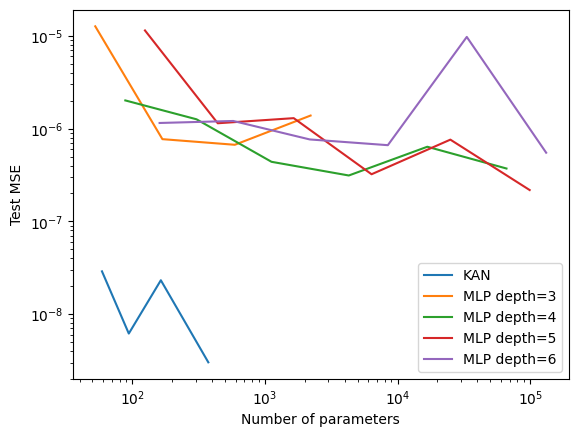

In [3]:
test_kan(ellipj,[[-1,1],[0,1]],[2,2,1],)

1
tensor(-0.4028, device='cuda:0') tensor(1.0000, device='cuda:0')
BetterKAN 5


train loss: 1.24e-01 | test loss: 1.26e-01 | reg: 0.00e+00 : 100%|██| 50/50 [00:20<00:00,  2.49it/s]


BetterKAN 10


train loss: 1.18e-01 | test loss: 1.18e-01 | reg: 0.00e+00 : 100%|██| 50/50 [00:07<00:00,  6.63it/s]


BetterKAN 20


train loss: 3.79e-03 | test loss: 3.80e-03 | reg: 0.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.32it/s]


BetterKAN 50


train loss: 2.22e-03 | test loss: 2.09e-03 | reg: 0.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.29it/s]
100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


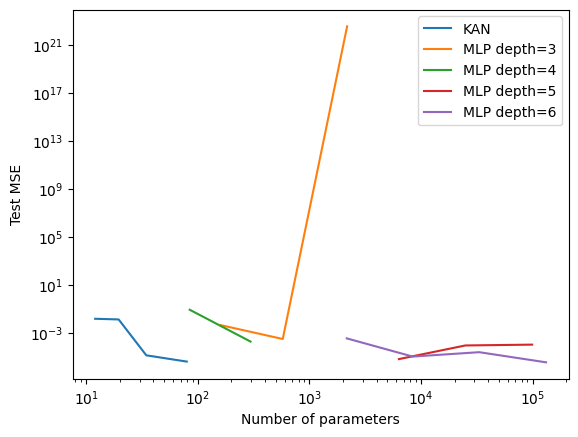

In [4]:
test_kan(test_accuracy_1,[[-1,1]],[1,1],)

2
tensor(0.3679, device='cuda:0') tensor(7.3618, device='cuda:0')
BetterKAN 5


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 8.44e-04 | test loss: 9.01e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:14<00:00,  3.51it/s]


BetterKAN 10


train loss: 4.68e-04 | test loss: 5.03e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:25<00:00,  1.97it/s]


BetterKAN 20


train loss: 5.03e-04 | test loss: 5.46e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:14<00:00,  3.44it/s]


BetterKAN 50


train loss: 9.94e-05 | test loss: 1.06e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:21<00:00,  2.37it/s]
100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


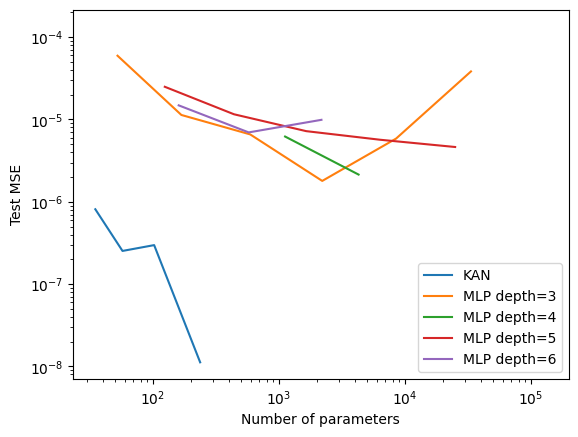

In [5]:
test_kan(test_accuracy_2,[[-1,1],[-1,1]],[2,1,1],)

4
tensor(0.7764, device='cuda:0') tensor(7.3888, device='cuda:0')
BetterKAN 5


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 8.65e-03 | test loss: 7.92e-03 | reg: 0.00e+00 : 100%|██| 50/50 [00:23<00:00,  2.17it/s]


BetterKAN 10


train loss: 1.43e-02 | test loss: 1.49e-02 | reg: 0.00e+00 : 100%|██| 50/50 [00:22<00:00,  2.21it/s]


BetterKAN 20


train loss: 2.34e-03 | test loss: 2.27e-03 | reg: 0.00e+00 : 100%|██| 50/50 [00:23<00:00,  2.14it/s]


BetterKAN 50


train loss: 9.75e-04 | test loss: 9.23e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:22<00:00,  2.18it/s]
100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


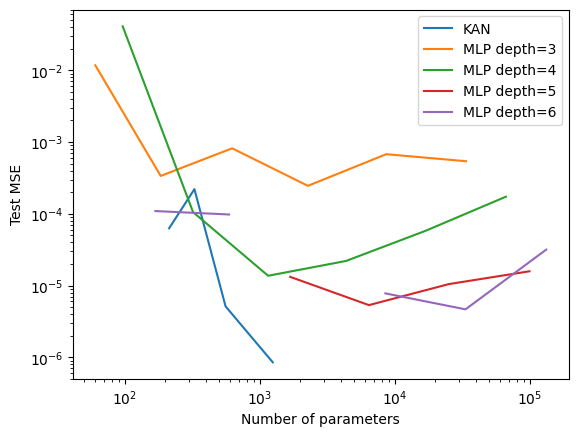

: 

In [9]:
test_kan( test_accuracy_4,[[-1,1],[-1,1],[-1,1],[-1,1]],[4,4,2,1],)

In [ ]:
test_kan(lpmv1,[[-1,1],[-1,1]],[2,3,1])


2
tensor(-0.9905, device='cuda:0') tensor(0.9921, device='cuda:0')
BetterKAN 5


train loss: 3.04e-04 | test loss: 2.90e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:19<00:00,  2.62it/s]


BetterKAN 10
torch.Size([1000, 2]) acts
torch.Size([1000, 2]) acts


train loss: 2.79e-04 | test loss: 2.68e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:06<00:00,  7.39it/s]


BetterKAN 20
torch.Size([1000, 2]) acts
torch.Size([1000, 2]) acts


train loss: 1.14e-04 | test loss: 1.07e-04 | reg: 0.00e+00 : 100%|██| 50/50 [00:17<00:00,  2.87it/s]


BetterKAN 50
torch.Size([1000, 2]) acts
torch.Size([1000, 2]) acts


train loss: 6.85e-05 | test loss: 6.93e-05 | reg: 0.00e+00 : 100%|██| 50/50 [00:16<00:00,  3.05it/s]
100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


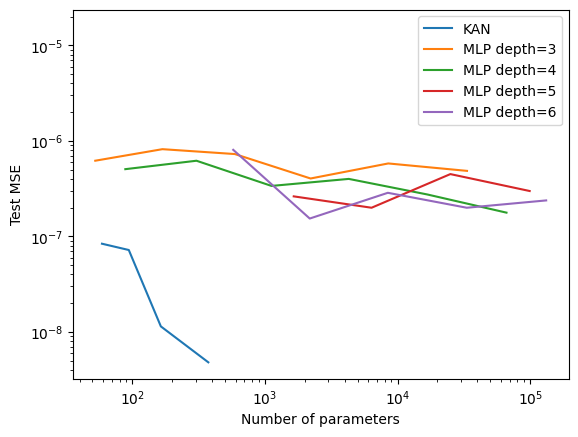

In [ ]:

test_kan(lpmv2,[[0,0],[1,1]],[2,3,2,1],)


In [ ]:
test_kan(ellipeinc,[[-1,1],[0,1]],[2,3,1])